# Time-series Forecasting

## Description
The data consists of 52,416 observations of energy consumption on a 10-minute window. Every observation is described by the following feature columns.

Your task is to **aggregate the observations on an interval of 30 minutes**. For this time interval, using the values of the **5 previous time intervals**, forecast the target value one step in the future. Choose which features you are going to use.

**You must train an LSTM network.**



Features:

* Datetime: Time window of ten minutes.
* Temperature: Weather Temperature.
* Humidity: Weather Humidity.
* WindSpeed: Wind Speed.
* GeneralDiffuseFlows: “Diffuse flow” is a catchall term to describe low-temperature (< 0.2° to ~ 100°C) fluids that slowly discharge through sulfide mounds, fractured lava flows, and assemblages of bacterial mats and macrofauna.
* DiffuseFlows

Target:

PowerConsumption

## Dataset links:
 * [DS1](https://drive.google.com/file/d/1k5Ee9kla-0s8iuEASsSY2u5hl6YstzlN/view?usp=sharing)
 * [DS2](https://drive.google.com/file/d/1--Kep6SOWuyQ2FTlBDdwWHj-65bOl1kc/view?usp=sharing)

## Read the datasets

In [ ]:
import pandas as pd
import numpy as np
import keras
from keras.layers import Input, Dense, LSTM, Embedding, concatenate
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [ ]:
data1 = pd.read_csv('/content/power_consumption_g1.csv')
data2 = pd.read_csv('/content/power_consumption_g1_feat.csv')

In [ ]:
data1.head(2)

,Datetime,PowerConsumption
0,2017-10-04 02:20:00,26802.27571
1,2017-05-28 13:20:00,32898.09836


In [ ]:
data2.head(2)

,Datetime,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows
0,2017-03-01 16:40:00,21.33,55.91,0.080,387.40,427.30
1,2017-07-27 06:30:00,23.10,48.58,4.908,10.45,8.63


In [ ]:
data1['Datetime'] = pd.to_datetime(data1['Datetime'])

In [ ]:
data1 = data1.set_index('Datetime').sort_index()

In [ ]:
data2['Datetime'] =  pd.to_datetime(data2['Datetime'])
data2 = data2.set_index('Datetime').sort_index()

## Merge the datasets (and pre-processing if needed)

In [ ]:
data = data2.merge(data1, how='inner', left_on='Datetime', right_on='Datetime')

In [ ]:
data.head(2)

,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,PowerConsumption
Datetime,,,,,,
2017-01-01 00:00:00,6.559,73.8,0.083,0.051,0.119,34055.69620
2017-01-01 00:10:00,6.414,74.5,0.083,0.070,0.085,29814.68354


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 52416 entries, 2017-01-01 00:00:00 to 2017-12-30 23:50:00
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Temperature          51857 non-null  float64
 1   Humidity             51917 non-null  float64
 2   WindSpeed            51887 non-null  float64
 3   GeneralDiffuseFlows  51892 non-null  float64
 4   DiffuseFlows         51911 non-null  float64
 5   PowerConsumption     52416 non-null  float64
dtypes: float64(6)
memory usage: 2.8 MB


In [ ]:
# sns plot here to see whether mean or median is better
# either impute with mean or median
data = data.fillna(data.mean())
data.isnull().sum()

Temperature            0
Humidity               0
WindSpeed              0
GeneralDiffuseFlows    0
DiffuseFlows           0
PowerConsumption       0
dtype: int64

In [ ]:
data.head(2)

,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,PowerConsumption
Datetime,,,,,,
2017-01-01 00:00:00,6.559,73.8,0.083,0.051,0.119,34055.69620
2017-01-01 00:10:00,6.414,74.5,0.083,0.070,0.085,29814.68354


## Group the datasets into time intervals of 30 mintues

In [ ]:
data = data.groupby(pd.Grouper(freq='30min')).mean()

In [ ]:
data.head(3)

,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,PowerConsumption
Datetime,,,,,,
2017-01-01 00:00:00,6.428667,74.266667,0.082000,0.061000,0.101333,30999.493670
2017-01-01 00:30:00,10.285226,75.866667,0.081667,0.066000,0.096333,27396.455697
2017-01-01 01:00:00,5.605000,74.688373,0.082000,0.056333,0.110000,25407.594937


## Create lags

In [ ]:
test_data = data.copy()
lag = 5
columns = data.columns.drop('PowerConsumption')
for i in range(1, lag+1):
  for col in columns:
    test_data[f'{col}_prev_{i}'] = test_data[col].shift(i)

In [ ]:
pd.set_option('display.max_columns', None)

In [ ]:
test_data.dropna()

,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,PowerConsumption,Temperature_prev_1,Humidity_prev_1,WindSpeed_prev_1,GeneralDiffuseFlows_prev_1,DiffuseFlows_prev_1,Temperature_prev_2,Humidity_prev_2,WindSpeed_prev_2,GeneralDiffuseFlows_prev_2,DiffuseFlows_prev_2,Temperature_prev_3,Humidity_prev_3,WindSpeed_prev_3,GeneralDiffuseFlows_prev_3,DiffuseFlows_prev_3,Temperature_prev_4,Humidity_prev_4,WindSpeed_prev_4,GeneralDiffuseFlows_prev_4,DiffuseFlows_prev_4,Temperature_prev_5,Humidity_prev_5,WindSpeed_prev_5,GeneralDiffuseFlows_prev_5,DiffuseFlows_prev_5
Datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-01-01 02:30:00,5.108000,79.100000,0.082000,0.061000,0.131000,21691.139240,5.000667,78.766667,0.082667,0.065000,0.127333,5.492667,77.166667,0.082000,0.057333,0.115000,5.605000,74.688373,0.082000,0.056333,0.110000,10.285226,75.866667,0.081667,0.066000,0.096333,6.428667,74.266667,0.082000,0.061000,0.101333
2017-01-01 03:00:00,5.097000,77.600000,0.082667,0.059667,0.130000,20992.405063,5.108000,79.100000,0.082000,0.061000,0.131000,5.000667,78.766667,0.082667,0.065000,0.127333,5.492667,77.166667,0.082000,0.057333,0.115000,5.605000,74.688373,0.082000,0.056333,0.110000,10.285226,75.866667,0.081667,0.066000,0.096333
2017-01-01 03:30:00,4.911667,76.566667,0.083000,0.060000,0.152000,20629.873417,5.097000,77.600000,0.082667,0.059667,0.130000,5.108000,79.100000,0.082000,0.061000,0.131000,5.000667,78.766667,0.082667,0.065000,0.127333,5.492667,77.166667,0.082000,0.057333,0.115000,5.605000,74.688373,0.082000,0.056333,0.110000
2017-01-01 04:00:00,4.952333,74.733333,0.083667,0.058667,0.117333,20512.405063,4.911667,76.566667,0.083000,0.060000,0.152000,5.097000,77.600000,0.082667,0.059667,0.130000,5.108000,79.100000,0.082000,0.061000,0.131000,5.000667,78.766667,0.082667,0.065000,0.127333,5.492667,77.166667,0.082000,0.057333,0.115000
2017-01-01 04:30:00,5.243000,73.366667,0.081000,0.057333,0.128333,20439.493670,4.952333,74.733333,0.083667,0.058667,0.117333,4.911667,76.566667,0.083000,0.060000,0.152000,5.097000,77.600000,0.082667,0.059667,0.130000,5.108000,79.100000,0.082000,0.061000,0.131000,5.000667,78.766667,0.082667,0.065000,0.127333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-30 21:30:00,7.913333,70.343333,0.081667,0.069333,0.087667,34786.311787,8.110000,69.006667,0.081333,0.077000,0.109000,9.150000,64.506667,0.086000,0.066000,0.090000,8.933333,63.473333,0.074667,0.039333,0.120000,9.196667,63.106667,0.074333,0.051333,0.095333,9.710000,63.878373,0.075000,0.052667,0.108667
2017-12-30 22:00:00,7.793333,69.563333,0.081000,0.062333,0.108667,34660.583017,7.913333,70.343333,0.081667,0.069333,0.087667,8.110000,69.006667,0.081333,0.077000,0.109000,9.150000,64.506667,0.086000,0.066000,0.090000,8.933333,63.473333,0.074667,0.039333,0.120000,9.196667,63.106667,0.074333,0.051333,0.095333
2017-12-30 22:30:00,7.403333,71.066667,0.082667,0.055000,0.107667,33326.235743,7.793333,69.563333,0.081000,0.062333,0.108667,7.913333,70.343333,0.081667,0.069333,0.087667,8.110000,69.006667,0.081333,0.077000,0.109000,9.150000,64.506667,0.086000,0.066000,0.090000,8.933333,63.473333,0.074667,0.039333,0.120000


# Split the dataset into 80% training and 20% testing datasets

In [ ]:
X = test_data.drop(columns='PowerConsumption')
Y = test_data['PowerConsumption']

In [ ]:
X = X.dropna(axis=0)

In [ ]:
Y = Y[5:]

In [ ]:
len(X) == len(Y)

True

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.8, shuffle=False)

## Create the model, pre-process the data and make it suitable for training

In [ ]:
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
scaler.fit(Y_train.values.reshape(-1, 1))
Y_train = scaler.transform(Y_train.values.reshape(-1, 1))
Y_test = scaler.transform(Y_test.values.reshape(-1, 1))

In [ ]:
X_train = X_train.reshape(-1, lag, X_train.shape[1] // lag)
X_test = X_test.reshape(-1, lag, X_test.shape[1] // lag)

In [ ]:
model = Sequential()
model.add(LSTM(128,  activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(LSTM(64,  activation='relu'))
model.add(Dense(1, activation='linear'))

## Train the model, use 20% of the training dataset for validation
Train with 10 epochs (due to time limit)

In [ ]:
model.compile(
    loss=keras.losses.MeanSquaredError(),
    optimizer=keras.optimizers.Adam(),
    metrics=[keras.metrics.MeanSquaredError(), ]
)

In [ ]:
history = model.fit(X_train, Y_train, batch_size=16, validation_split=0.2, epochs=10, shuffle=False)

Epoch 1/10
699/699 [==============================] - 12s 12ms/step - loss: 0.0324 - mean_squared_error: 0.0324 - val_loss: 0.0240 - val_mean_squared_error: 0.0240
Epoch 2/10
699/699 [==============================] - 7s 10ms/step - loss: 0.0213 - mean_squared_error: 0.0213 - val_loss: 0.0198 - val_mean_squared_error: 0.0198
Epoch 3/10
699/699 [==============================] - 8s 11ms/step - loss: 0.0186 - mean_squared_error: 0.0186 - val_loss: 0.0164 - val_mean_squared_error: 0.0164
Epoch 4/10
699/699 [==============================] - 9s 12ms/step - loss: 0.0175 - mean_squared_error: 0.0175 - val_loss: 0.0165 - val_mean_squared_error: 0.0165
Epoch 5/10
699/699 [==============================] - 7s 11ms/step - loss: 0.0167 - mean_squared_error: 0.0167 - val_loss: 0.0183 - val_mean_squared_error: 0.0183
Epoch 6/10
699/699 [==============================] - 9s 13ms/step - loss: 0.0161 - mean_squared_error: 0.0161 - val_loss: 0.0194 - val_mean_squared_error: 0.0194
Epoch 7/10
699/699 [=

## Plot the loss function on the training and validation dataset

In [ ]:
history.history['val_loss']

[0.02400921657681465,
 0.019778484478592873,
 0.016420762985944748,
 0.016521355137228966,
 0.018304288387298584,
 0.019359886646270752,
 0.01965596154332161,
 0.019302820786833763,
 0.018972883000969887,
 0.018559180200099945]

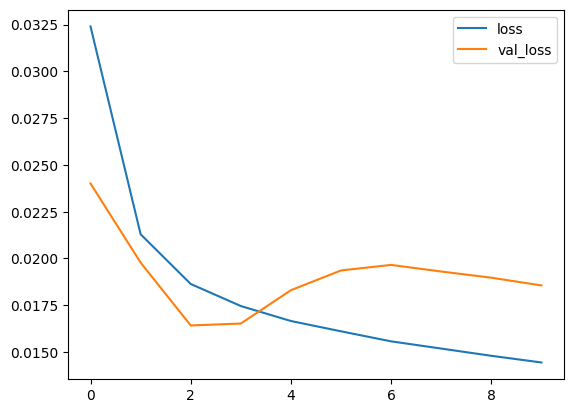

In [ ]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

## Calculate the adequate metrics

In [ ]:
preds = scaler.inverse_transform(model.predict(X_test))

110/110 [==============================] - 1s 6ms/step


In [ ]:
Y_test = scaler.inverse_transform(Y_test)

In [ ]:
preds

array([[29356.885],
       [31641.861],
       [29220.584],
       ...,
       [25091.252],
       [24762.38 ],
       [24406.553]], dtype=float32)

In [ ]:
mean_squared_error(preds, Y_test), mean_absolute_error(preds, Y_test), r2_score(preds, Y_test)

(40113315.64747854, 5509.869280044124, -0.05402805698649926)

## Visualize the targets against the predictions

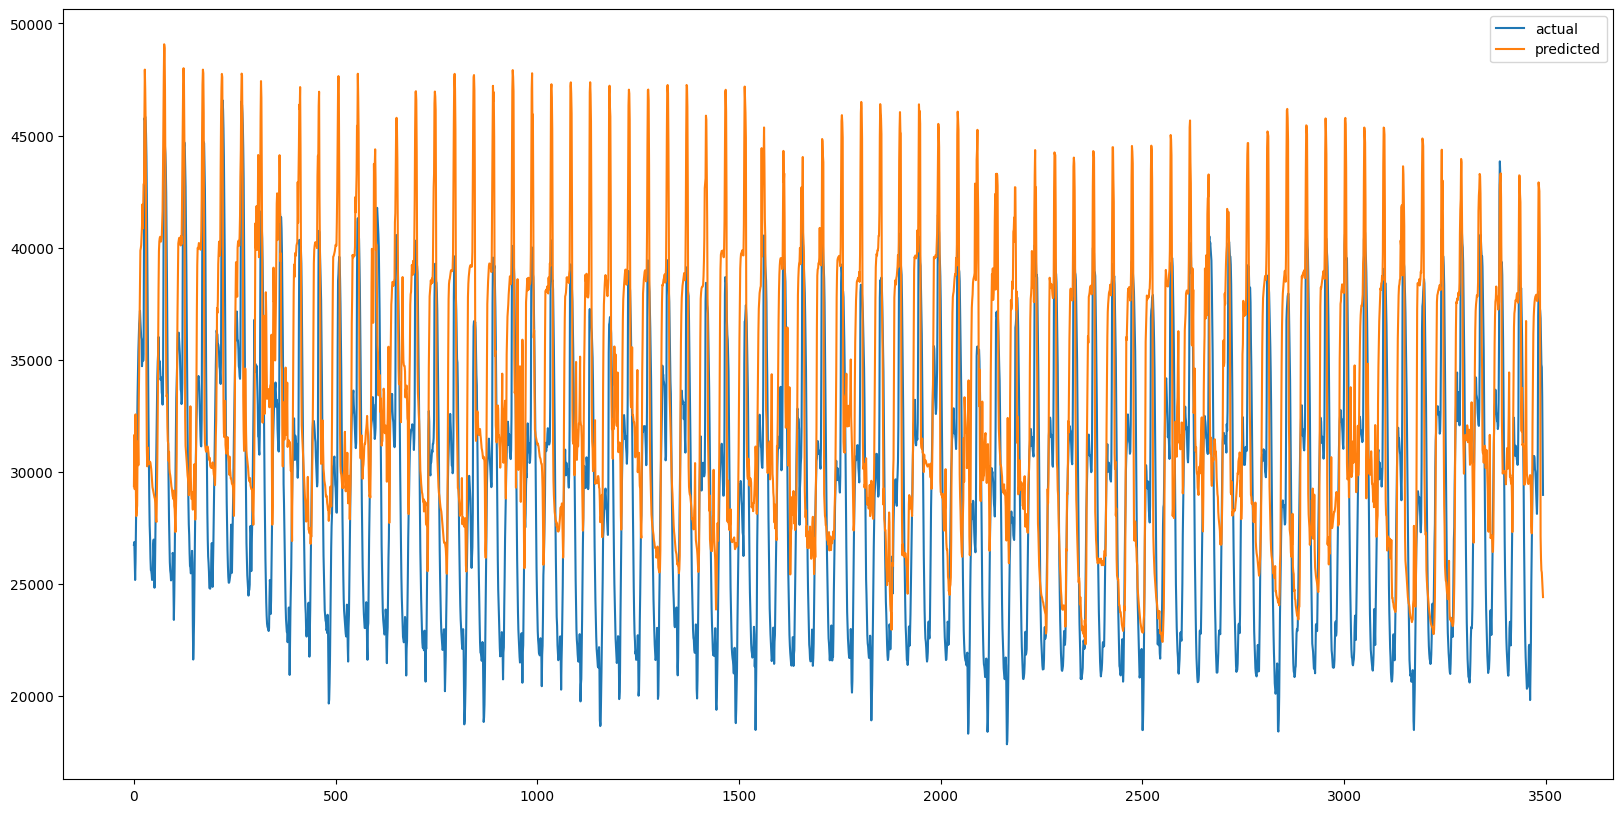

In [ ]:
plt.figure(figsize=(20, 10))
plt.plot(Y_test, label='actual')
plt.plot(preds, label='predicted')
plt.legend()
plt.show()